In this exercise I solve a deterministic growth model using simulated data generated from an economy with parameters $\beta = 0.95$, $\alpha = 0.3$, $A = 1.0$, $\delta = 0.05$, $\gamma = 2.0$. I initiate the variables of the mathematical program at the true values, which should make the optimization easy.

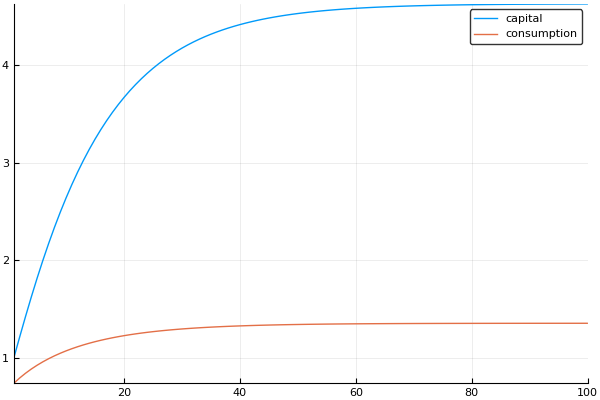

In [1]:
using CSV
using Plots; pyplot()

df = CSV.read("data.csv"; header=false, types=[Float64, Float64])
dataK = convert(Vector{Float64}, df[1])
dataC = convert(Vector{Float64}, df[2])

plot(dataK, label="capital")
plot!(dataC, label="consumption")

The economy's steady state for capital is:

In [2]:
k_stst = 4.628988089138438;

# The Mathematical Program
I define the needed function related to utility and production:

In [3]:
u_crra_prime(c, γ) = begin
    if (c <= 0)
        return -1000000.
        else
        return c^-γ
    end
end

u_crra_prime_inv(u, γ) = begin
    if (u <= 0)
        return +1000000.
    else
        return u^(-1/γ) 
    end
end

function f(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*k^α
    end
end

function f_prime(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*α*k^(α-1)
    end
end

f_prime (generic function with 1 method)

I use the Julia Mathematical Programming languange JuMP and the IpOpt solver:

In [19]:
using JuMP
using Gurobi, Ipopt

m = Model(solver=IpoptSolver(print_level=5, max_iter=600));
#m = Model(solver=GurobiSolver());

I define the deep parameters variables and give the the correct starting values:

In [5]:
@variable(m, 0 <= β <= 1, start = 0.90)
@variable(m, 0 <= δ <= 1, start = 0.05)
@variable(m, 0 <= α <= 1, start = 0.3)
@variable(m, A >= 0, start = 1)
@variable(m, γ >= 0, start = 2);

LoadError: [91mUndefVarError: m not defined[39m

The policy function is approximated by 10 Chebyshev polynomials on a grid around the steady state for capital, the coefficients on the polynomials are $\theta$:

In [6]:
@variable(m, θ[1:10], start = 0)

#setvalue(θ[1], 0.1);

LoadError: [91mUndefVarError: m not defined[39m

I define a grid on capital, $K$, with 10 nodes, and evaluate the Chebyshev polynomials at those point into $\Psi$ and at the observed data points into $\Phi$:

In [7]:
using BasisMatrices
basis = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))
K = nodes(basis)[1] #grid
Ψ = BasisMatrix(basis, Expanded(), K).vals[1]
Φ = BasisMatrix(basis, Expanded(), dataK).vals[1];

INFO: Precompiling module BasisMatrices.
ERROR: LoadError: NLopt not properly installed. Please run Pkg.build("NLopt")
Stacktrace:
 [1] error(::String) at ./error.jl:21
 [2] include_from_node1(::String) at ./loading.jl:576
 [3] include(::String) at ./sysimg.jl:14
 [4] anonymous at ./<missing>:2
while loading /Users/Max/.julia/v0.6/NLopt/src/NLopt.jl, in expression starting on line 22
ERROR: LoadError: LoadError: Failed to precompile NLopt to /Users/Max/.julia/lib/v0.6/NLopt.ji.
Stacktrace:
 [1] compilecache(::String) at ./loading.jl:710
 [2] _require(::Symbol) at ./loading.jl:463
 [3] require(::Symbol) at ./loading.jl:405
 [4] include_from_node1(::String) at ./loading.jl:576
 [5] include(::String) at ./sysimg.jl:14
 [6] include_from_node1(::String) at ./loading.jl:576
 [7] include(::String) at ./sysimg.jl:14
 [8] anonymous at ./<missing>:2
while loading /Users/Max/.julia/v0.6/QuantEcon/src/markov/markov_approx.jl, in expression starting on line 15
while loading /Users/Max/.julia/v0.6/Q

LoadError: [91mFailed to precompile BasisMatrices to /Users/Max/.julia/lib/v0.6/BasisMatrices.ji.[39m

And I initialize $\theta$ such that the consumer myopically consumes almost everything available, leaving just $0.1$ capital for the next period:

In [8]:
initial_θ = Ψ \ (f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - .1)

for i in 1:10
    setvalue(θ[i], initial_θ[i])
end

LoadError: [91mUndefVarError: Ψ not defined[39m

In the equilibrium constraint the polynomials have to be evaluated also outside the grid, I define this function here:

In [9]:
function Ψprime(x, order)
    k_stst = 4.628988089138438
    a = 0.2*k_stst
    b = 2*k_stst
    
    z = (2/(b-a)) * (x-(a+b)/2)
    
    if (order == 1)
        return 1.
    elseif (order == 2)
        return z
    else
        
        out1 = 1.
        out2 = z
        out3 = 0.

        for j in 3:order
            out3 = 2. * z * out2 - out1
            out1 = out2
            out2 = out3
        end

        return out3
    end
end

Ψprime (generic function with 1 method)

I define auxiliary variables for model predictions of capital and consumption:

In [10]:
@variable(m, modelC[i=1:10], start = 1)
@variable(m, modelCprime[i=1:10], start = 1)
@variable(m, modelKprime[i=1:10], start = 1);

LoadError: [91mUndefVarError: m not defined[39m

I register all user-defined functions with JuMP for automatic differentiation:

In [11]:
JuMP.register(m, :Ψprime, 2, Ψprime, autodiff=true)
JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)

LoadError: [91mUndefVarError: m not defined[39m

The auxiliary and equilibrium constraints are all defined on the grid with 10 nodes:

In [12]:
@NLconstraint(m, cons_today[i=1:10], modelC[i] == sum(Ψ[i, k] * θ[k] for k in 1:10))
@NLconstraint(m, capi_tomor[i=1:10], modelKprime[i] == f(K[i], α, A) + (1-δ)*K[i] - modelC[i]) 
@NLconstraint(m, cons_tomor[i=1:10], modelCprime[i] == sum(Ψprime(modelKprime[i], k) * θ[k] for k in 1:10))

@NLconstraint(m, EE[i=1:10], modelC[i] == u_crra_prime_inv(
    β * u_crra_prime(modelCprime[i], γ) * (f_prime(modelKprime[i], α, A) + 1-δ), γ));

LoadError: [91mUndefVarError: m not defined[39m

I define auxiliary expressions for the predictions of the equilibrium conditions:

In [13]:
@NLexpression(m, p
    redictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])
@NLexpression(m, predictedC[t=1:100], sum(Φ[t, k] * θ[k] for k in 1:10));

LoadError: [91mUndefVarError: m not defined[39m

The objective is to minimize the sum of squared errors:

In [14]:
@NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))

LoadError: [91mUndefVarError: m not defined[39m

In [15]:
solve(m)

LoadError: [91mUndefVarError: m not defined[39m

In [16]:
getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)

LoadError: [91mUndefVarError: β not defined[39m

In [17]:
plot(nodes(Basis(ChebParams(10, 0.2*k_stst, 2*k_stst)))[1], [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393], label="True Policy Fucntion")
plot!(K, Ψ * getvalue(θ), label="Estimated Policy Function")

LoadError: [91mUndefVarError: nodes not defined[39m

# Robustness in $\beta$
Varying the initial value for $\beta$ uncovers severe robustness issues:

In [18]:
error = zeros(50)
initial_β = linspace(0.95-0.2, 0.95+0.2, 50)

for test in 1:50
    m = Model(solver=IpoptSolver(print_level=0, max_iter=600));
    
    @variable(m, 0 <= β <= 1, start = initial_β[test])
    @variable(m, 0 <= δ <= 1, start = 0.05) #rand(Normal(0.05, 0.1)))
    @variable(m, 0 <= α <= 1, start = 0.3) #rand(Normal(0.3, 0.1)))
    @variable(m, A >= 0, start = 1) #rand(Normal(1., 0.1)))
    @variable(m, γ >= 0, start = 2) #rand(Normal(2., 0.1)));
    @variable(m, θ[1:10], start = 0)
    
    initial_θ = Ψ \ (f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - 0.1)

    for i in 1:10
        setvalue(θ[i], initial_θ[i])
    end
    
    @variable(m, modelC[i=1:10], start = 1)
    @variable(m, modelCprime[i=1:10], start = 1)
    @variable(m, modelKprime[i=1:10], start = 1);
        JuMP.register(m, :Ψprime, 2, Ψprime, autodiff=true)
    JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
    JuMP.register(m, :f, 3, f, autodiff=true)
    JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
    JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)
        @NLconstraint(m, cons_today[i=1:10], modelC[i] == sum(Ψ[i, k] * θ[k] for k in 1:10))
    @NLconstraint(m, capi_tomor[i=1:10], modelKprime[i] == f(K[i], α, A) + (1-δ)*K[i] - modelC[i]) 
    @NLconstraint(m, cons_tomor[i=1:10], modelCprime[i] == sum(Ψprime(modelKprime[i], k) * θ[k] for k in 1:10))

    @NLconstraint(m, EE[i=1:10], modelC[i] == u_crra_prime_inv(
    β * u_crra_prime(modelCprime[i], γ) * (f_prime(modelKprime[i], α, A) + 1-δ), γ));
    @NLexpression(m, predictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])
    @NLexpression(m, predictedC[t=1:100], sum(Φ[t, k] * θ[k] for k in 1:10));
    @NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))
    solve(m);
    error[test] = maximum(abs.([getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)] - [0.95, 0.05, 0.3, 1, 2]))
end

plot(initial_β, error, ylim=[-0.05,0.05])

LoadError: [91mUndefVarError: IpoptSolver not defined[39m

The correct solution is not robustly found!